In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


path_dir1 = 'C:/Users/erer0/Desktop/concentrate_dataset/Desktop/no_con_faces/'
path_dir2 = 'C:/Users/erer0/Desktop/concentrate_dataset/Desktop/con_faces/'

file_list1 = os.listdir(path_dir1) # path에 존재하는 파일 목록 가져오기
file_list2 = os.listdir(path_dir2)

file_list1_num = len(file_list1)
file_list2_num = len(file_list2)

file_num = file_list1_num + file_list2_num


#%% 이미지 전처리
num = 0;
all_img = np.float32(np.zeros((file_num, 224, 224, 3))) 
all_label = np.float64(np.zeros((file_num, 1)))

for img_name in file_list1:
    img_path = path_dir1+img_name
    img = load_img(img_path, target_size=(224, 224))
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x
    
    all_label[num] = 0 # not_concentrate
    num = num + 1
    
for img_name in file_list2:
    img_path = path_dir2+img_name
    img = load_img(img_path, target_size=(224, 224))
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x
    
    all_label[num] = 1 # concentrate
    num = num + 1
 
 
# 데이터셋 섞기(적절하게 훈련되게 하기 위함) 
n_elem = all_label.shape[0]
indices = np.random.choice(n_elem, size=n_elem, replace=False)
 
all_label = all_label[indices]
all_img = all_img[indices]


# 훈련셋 테스트셋 분할
num_train = int(np.round(all_label.shape[0]*0.8))
num_test = int(np.round(all_label.shape[0]*0.2))
 
train_img = all_img[0:num_train, :, :, :]
test_img = all_img[num_train:, :, :, :] 
 
train_label = all_label[0:num_train]
test_label = all_label[num_train:]
 
 
 
#%% 
# create the base pre-trained model
IMG_SHAPE = (224, 224, 3)
 
base_model = ResNet50(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()
print("Number of layers in the base model: ", len(base_model.layers))
 
flatten_layer = Flatten()
dense_layer1 = Dense(128, activation='relu')
bn_layer1 = BatchNormalization()
dense_layer2 = Dense(1, activation=tf.nn.sigmoid)
 
model = Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        bn_layer1,
        dense_layer2,
        ])
 
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
 
history = model.fit(train_img, train_label, epochs=10, batch_size=16, validation_data = (test_img, test_label))
 

# save model
model.save("model.h5")
 
print("Saved model to disk")

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,433,537
Trainable params: 12,845,569
Non-trainable params: 23,587,968
_________________________________

In [18]:
# import necessary packages
import cvlib as cv
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import ImageFont, ImageDraw, Image


model = load_model('model5.h5')
model.summary()
 
# open webcam
webcam = cv2.VideoCapture(0)


if not webcam.isOpened():
    print("Could not open webcam")
    exit()

    
# loop through frames
while webcam.isOpened():
 
    # read frame from webcam 
    status, frame = webcam.read()
    
    if not status:
        print("Could not read frame")
        exit()
 
    # apply face detection
    face, confidence = cv.detect_face(frame)
 
    # loop through detected faces
    for idx, f in enumerate(face):
        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
        
        if 0 <= startX <= frame.shape[1] and 0 <= endX <= frame.shape[1] and 0 <= startY <= frame.shape[0] and 0 <= endY <= frame.shape[0]:
            
            face_region = frame[startY:endY, startX:endX]
            
            face_region1 = cv2.resize(face_region, (224, 224), interpolation = cv2.INTER_AREA)
            
            x = img_to_array(face_region1)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            prediction = model.predict(x)
 
            if prediction < 0.5: # 비집중으로 판별되면, 
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,0,255), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = "Not_Concentrate ({:.2f}%)".format((1 - prediction[0][0])*100)
                cv2.putText(frame, text, (startX,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
                
            else: # 집중으로 판별되면
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = "Concentrate ({:.2f}%)".format(prediction[0][0]*100)
                cv2.putText(frame, text, (startX,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
                
    # display output
    cv2.imshow("focus classify", frame)
 
    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# release resources
webcam.release()
cv2.destroyAllWindows()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,433,537
Trainable params: 12,845,569
Non-trainable params: 23,587,968
_________________________________

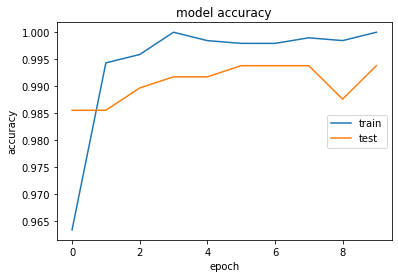

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 5)
plt.show()